In [1]:
# Library
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import lightgbm as lgb
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from sklearn.feature_selection import RFE
from sklearn.preprocessing import FunctionTransformer
from sklego.preprocessing import RepeatingBasisFunction
from tqdm.auto import tqdm

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
seed = 42

In [3]:
train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')
submission_df = pd.read_csv('../data/submission.csv')

In [4]:
def preprocessing(df, mode='train'):
    df_tmp = df.copy()
    input_year = 2021

    df_tmp['time'] = pd.to_datetime(df_tmp.date, format='%m/%d')
    df_tmp['year'] = df_tmp['time'].dt.year
    df_tmp['month'] = df_tmp['time'].dt.month
    df_tmp['day'] = df_tmp['time'].dt.day
    
    if mode=='train':
        df_tmp.loc[df_tmp['month']>3, 'year'] = input_year
        df_tmp.loc[df_tmp['month']<=3, 'year'] = input_year + 1
    else:
        df_tmp['year'] = input_year + 1
    df_tmp['time'] = pd.to_datetime({'year':df_tmp.year, 'month':df_tmp.month, 'day':df_tmp.day})
    df_tmp['weekday'] = df_tmp['time'].dt.weekday
    df_tmp['day_of_year'] = df_tmp['time'].dt.day_of_year
    return df_tmp

train_df = preprocessing(train_df, mode='train')
test_df = preprocessing(test_df, mode='test')

In [5]:
train_df.columns

Index(['id', 'date', 'highest', 'lowest', 'rain', 'ice1', 'ice2', 'ice3',
       'oden1', 'oden2', 'oden3', 'oden4', 'hot1', 'hot2', 'hot3', 'dessert1',
       'dessert2', 'dessert3', 'dessert4', 'dessert5', 'drink1', 'drink2',
       'drink3', 'drink4', 'drink5', 'drink6', 'alcol1', 'alcol2', 'alcol3',
       'snack1', 'snack2', 'snack3', 'bento1', 'bento2', 'bento3', 'bento4',
       'tild1', 'tild2', 'men1', 'men2', 'men3', 'men4', 'men5', 'men6',
       'time', 'year', 'month', 'day', 'weekday', 'day_of_year'],
      dtype='object')

In [6]:
target_columns = ['ice1', 'ice2', 'ice3',
    'oden1', 'oden2', 'oden3', 'oden4', 'hot1', 'hot2', 'hot3', 'dessert1',
    'dessert2', 'dessert3', 'dessert4', 'dessert5', 'drink1', 'drink2',
    'drink3', 'drink4', 'drink5', 'drink6', 'alcol1', 'alcol2', 'alcol3',
    'snack1', 'snack2', 'snack3', 'bento1', 'bento2', 'bento3', 'bento4',
    'tild1', 'tild2', 'men1', 'men2', 'men3', 'men4', 'men5', 'men6']

In [7]:
all_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [8]:
# # sin,cos変換を適用
# def sin_transformer(period):
#     return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

# def cos_transformer(period):
#     return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# all_df_sincos = all_df.copy()
# all_df_sincos['day_of_year'] = all_df.time.dt.day_of_year

# # month -> sin, cos
# all_df_sincos['month_sin'] = sin_transformer(12).fit_transform(all_df_sincos['month'])
# all_df_sincos['month_cos'] = cos_transformer(12).fit_transform(all_df_sincos['month'])

# # week -> sin, cos
# all_df_sincos['weekday_sin'] = sin_transformer(7).fit_transform(all_df_sincos['weekday'])
# all_df_sincos['weekday_cos'] = cos_transformer(7).fit_transform(all_df_sincos['weekday'])

# # day -> sin, cos
# all_df_sincos['day_sin'] = sin_transformer(365).fit_transform(all_df_sincos['day_of_year'])
# all_df_sincos['day_cos'] = cos_transformer(365).fit_transform(all_df_sincos['day_of_year'])


# fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16,8))
# all_df_sincos[["month_sin", "month_cos"]].plot(ax=ax[0])
# all_df_sincos[["weekday_sin", "weekday_cos"]].plot(ax=ax[1])
# all_df_sincos[["day_sin", "day_cos"]].plot(ax=ax[2])
# plt.suptitle("Cyclical encoding with sine/cosine transformation")

In [9]:
# # 放射状基底関数
# all_df_sincos_rbf = all_df_sincos.copy()

# rbf = RepeatingBasisFunction(n_periods=12, column='day_of_year', input_range=(1, 365), remainder='drop')
# rbf.fit(all_df_sincos_rbf)

# tmp_column = [f'month_rbf_{i}' for i in range(1, 13)]
# day_of_year_rbf = pd.DataFrame(columns=tmp_column, data=rbf.transform(all_df_sincos_rbf))

# # 放射状基底関数を結合
# all_df_sincos_rbf = pd.merge(all_df_sincos_rbf, day_of_year_rbf, left_index=True, right_index=True)

# # プロット
# day_of_year_rbf.plot(subplots=True, figsize=(14, 8),
#      	sharex=True, title="Radial Basis Functions",
#      	legend=False)

In [10]:
# # train, test に分ける
# train_df_sincos_rbf = all_df_sincos_rbf.iloc[:350, :]
# test_df_sincos_rbf = all_df_sincos_rbf.iloc[350:, :].dropna(axis=1)

In [11]:
# 検証データのindexを指定(訓練データの最後2ヶ月を使用)
# valid_index = range(297,351) # month: 2,3
valid_index = range(325,351) # month: 3
# valid_index = range(1, 21) # month: 4

# 予測結果を保存する辞書型データ
results = dict({})
all_lgb_score = []

# 商品ごとの予測を作成

for c in tqdm(target_columns):
    # train_tmp = train_df_sincos_rbf.copy()
    train_tmp = train_df.copy()
    # test_tmp = test_df_sincos_rbf.copy()
    test_tmp = test_df.copy()
    
    #ice
    if c in ['ice1', 'ice2', 'ice3']:
        # 予測期間はアイスが人気な7, 8 ,9月ではないので除外
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        # アイスは金曜に人気
        train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
        test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
    # oden
    elif c in ['oden1', 'oden2', 'oden3', 'oden4']:
        # おでんやって無い夏は考えない
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        # おでんは水木で人気
        train_tmp['is_wday23'] = train_df['weekday'].isin([2, 3]).astype(int)
        test_tmp['is_wday23'] = test_df['weekday'].isin([2, 3]).astype(int)
    # hot
    elif c in ['hot1', 'hot2', 'hot3']:
        # ホットスナックは月、火、金で不人気
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    # dessert
    elif c in ['dessert1', 'dessert2', 'dessert3', 'dessert4', 'dessert5']:
        # デザートは水曜と日曜で人気
        train_tmp['is_wday36'] = train_df['weekday'].isin([3,6]).astype(int)
        test_tmp['is_wday36'] = test_df['weekday'].isin([3,6]).astype(int)
    # drink1234
    elif c in ['drink1', 'drink2', 'drink3', 'drink4']:
        # 夏に人気なドリンクは夏のデータは使わない
        train_tmp = train_tmp[~train_tmp['month'].isin([7, 8, 9])]
        if c in ['drink1', 'drink4']:
            # 金曜に人気
            train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
            test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
        else:
            # 常に人気が変わらないドリンクは全期間つかう。火曜に人気
            train_tmp['is_wday1'] = train_df['weekday'].isin([1]).astype(int)
            test_tmp['is_wday1'] = test_df['weekday'].isin([1]).astype(int)
    # drink5
    elif c in ['drink5']:
        # 金曜に人気
        train_tmp['is_wday4'] = train_df['weekday'].isin([4]).astype(int)
        test_tmp['is_wday4'] = test_df['weekday'].isin([4]).astype(int)
    # drink6
    elif c in ['drink6']:
        # 日曜に人気
        train_tmp['is_wday6'] = train_df['weekday'].isin([6]).astype(int)
        test_tmp['is_wday6'] = test_df['weekday'].isin([6]).astype(int)
    # alcohol
    elif c in ['alcol1', 'alcol2', 'alcol3']:
        # 酒は水木で人気
        train_tmp['is_wday23'] = train_df['weekday'].isin([2, 3]).astype(int)
        test_tmp['is_wday23'] = test_df['weekday'].isin([2, 3]).astype(int)
    # snack
    elif c in ['snack1', 'snack2', 'snack3']:
        train_tmp['is_wday0'] = train_df['weekday'].isin([0]).astype(int)
        train_tmp['is_wday14'] = train_df['weekday'].isin([1,4]).astype(int)
        test_tmp['is_wday0'] = test_df['weekday'].isin([0]).astype(int)
        test_tmp['is_wday14'] = test_df['weekday'].isin([1,4]).astype(int)
    # bento
    elif c in ['bento1', 'bento2', 'bento3', 'bento4']:
        # 弁当は月、火、金で不人気
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    # tild
    elif c in ['tild1', 'tild2']:
        # 日曜に人気
        train_tmp['is_wday6'] = train_df['weekday'].isin([6]).astype(int)
        test_tmp['is_wday6'] = test_df['weekday'].isin([6]).astype(int)
    # men
    elif c in ['men1', 'men2', 'men3', 'men4', 'men5', 'men6']:
        train_tmp['is_wday014'] = train_df['weekday'].isin([0,1,4]).astype(int)
        test_tmp['is_wday014'] = test_df['weekday'].isin([0,1,4]).astype(int)
    
    # 訓練に確実に不必要なデータを除く
    train_columns = [c for c in train_tmp.columns if c not in target_columns if c not in\
    # ['id', 'date', 'time', 'month', 'year', 'day', 'weekday', 'day_of_year']]
        ['id', 'date', 'time']]
    
    # データを訓練、検証に分割
    X_train = train_tmp[~train_tmp['id'].isin(valid_index)][train_columns]
    y_train = train_tmp[~train_tmp['id'].isin(valid_index)][c]
    X_valid = train_tmp[train_tmp['id'].isin(valid_index)][train_columns]
    y_valid = train_tmp[train_tmp['id'].isin(valid_index)][c]
     
    # テストデータ
    X_test = test_tmp[train_columns]

    # 分位点
    qs = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
    
    # 分位点ごとのスコア
    q_scores = []
    
    # 分位点ごとにモデルを作成
    for q in qs:
        lgb = LGBMRegressor(
            objective='quantile',
            alpha = q,
            n_estimators=10000,
            colsample_bytree=0.9,
            random_state=seed,
            max_depth=5,
        )
        
        # # RFEにより特徴量選択
        # selector = RFE(lgb, n_features_to_select=0.6)
        # selector.fit(X_train, y_train)
        
        # # 特徴量が生き残ったか（残った：True、ドロップ：False）を表示
        # result = pd.DataFrame(selector.get_support(), index=X_train.columns.values, columns=['left'])
        # result['ranking'] = selector.ranking_
        # print(f'---{c}_{q}---')
        # display(result.T)
        # print(' ')
        
        # このモデルで採用されたカラム
        # train_columns_RFE = X_train.columns.values[selector.get_support()]
        
        # # 採用されたカラムだけでデータを作成
        # X_train_RFE = X_train[train_columns_RFE]
        # X_valid_RFE = X_valid[train_columns_RFE]
        # X_test_RFE = X_test[train_columns_RFE]
        
        
        # 学習
        lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose=False)
        score = lgb.best_score_['valid_0']['quantile']
        
        y_pred = lgb.predict(X_test)
        results[(c, q)] = y_pred
        
        q_scores.append(score)

    all_lgb_score.append(q_scores)

score_df = pd.DataFrame(np.array(all_lgb_score), columns=qs, index=target_columns)
display(score_df)

print(f'ave score: {np.array(all_lgb_score).mean()}')

  0%|          | 0/39 [00:00<?, ?it/s]

,0.01,0.10,0.50,0.90,0.99
ice1,0.035231,0.261459,0.808972,0.575586,0.089615
ice2,0.171643,0.343730,0.433284,0.879530,0.228448
ice3,0.054523,0.448462,1.378846,0.444239,0.080227
oden1,0.473534,1.086877,2.844364,1.548829,0.278879
oden2,0.248911,1.046709,3.141214,1.528414,0.281752
oden3,0.381475,1.749487,4.285037,2.609950,0.661377
oden4,0.348506,1.569710,4.673192,4.071986,1.083020
hot1,0.271771,1.226096,3.660201,1.334646,0.745947
hot2,0.256462,2.148908,6.363941,2.729525,0.351232
hot3,0.312402,2.384146,5.522259,2.271541,0.210540


ave score: 0.7412706596597352


In [12]:
submit_rows = [[f'{k[0]}_{k[1]}'] + v.tolist() for k, v in results.items()]

In [22]:
# submitファイルを作成
# データを整数に丸めることでわずかに精度が上がるらしい
submit_df_1 = pd.DataFrame(np.array(submit_rows)[:, 1:22].astype(float).round(), index=np.array(submit_rows)[:, 0], columns=range(1, 22))
# 転置
submit_df_1 = submit_df_1.transpose()
submit_df_1.index.name = 'id'
display(submit_df_1)

,ice1_0.01,ice1_0.1,ice1_0.5,ice1_0.9,ice1_0.99,ice2_0.01,ice2_0.1,ice2_0.5,ice2_0.9,ice2_0.99,ice3_0.01,ice3_0.1,ice3_0.5,ice3_0.9,ice3_0.99,oden1_0.01,oden1_0.1,oden1_0.5,oden1_0.9,oden1_0.99,oden2_0.01,oden2_0.1,oden2_0.5,oden2_0.9,oden2_0.99,oden3_0.01,oden3_0.1,oden3_0.5,oden3_0.9,oden3_0.99,oden4_0.01,oden4_0.1,oden4_0.5,oden4_0.9,oden4_0.99,hot1_0.01,hot1_0.1,hot1_0.5,hot1_0.9,hot1_0.99,hot2_0.01,hot2_0.1,hot2_0.5,hot2_0.9,hot2_0.99,hot3_0.01,hot3_0.1,hot3_0.5,hot3_0.9,hot3_0.99,dessert1_0.01,dessert1_0.1,dessert1_0.5,dessert1_0.9,dessert1_0.99,dessert2_0.01,dessert2_0.1,dessert2_0.5,dessert2_0.9,dessert2_0.99,dessert3_0.01,dessert3_0.1,dessert3_0.5,dessert3_0.9,dessert3_0.99,dessert4_0.01,dessert4_0.1,dessert4_0.5,dessert4_0.9,dessert4_0.99,dessert5_0.01,dessert5_0.1,dessert5_0.5,dessert5_0.9,dessert5_0.99,drink1_0.01,drink1_0.1,drink1_0.5,drink1_0.9,drink1_0.99,drink2_0.01,drink2_0.1,drink2_0.5,drink2_0.9,drink2_0.99,drink3_0.01,drink3_0.1,drink3_0.5,drink3_0.9,drink3_0.99,drink4_0.01,drink4_0.1,drink4_0.5,drink4_0.9,drink4_0.99,drink5_0.01,drink5_0.1,drink5_0.5,drink5_0.9,drink5_0.99,drink6_0.01,drink6_0.1,drink6_0.5,drink6_0.9,drink6_0.99,alcol1_0.01,alcol1_0.1,alcol1_0.5,alcol1_0.9,alcol1_0.99,alcol2_0.01,alcol2_0.1,alcol2_0.5,alcol2_0.9,alcol2_0.99,alcol3_0.01,alcol3_0.1,alcol3_0.5,alcol3_0.9,alcol3_0.99,snack1_0.01,snack1_0.1,snack1_0.5,snack1_0.9,snack1_0.99,snack2_0.01,snack2_0.1,snack2_0.5,snack2_0.9,snack2_0.99,snack3_0.01,snack3_0.1,snack3_0.5,snack3_0.9,snack3_0.99,bento1_0.01,bento1_0.1,bento1_0.5,bento1_0.9,bento1_0.99,bento2_0.01,bento2_0.1,bento2_0.5,bento2_0.9,bento2_0.99,bento3_0.01,bento3_0.1,bento3_0.5,bento3_0.9,bento3_0.99,bento4_0.01,bento4_0.1,bento4_0.5,bento4_0.9,bento4_0.99,tild1_0.01,tild1_0.1,tild1_0.5,tild1_0.9,tild1_0.99,tild2_0.01,tild2_0.1,tild2_0.5,tild2_0.9,tild2_0.99,men1_0.01,men1_0.1,men1_0.5,men1_0.9,men1_0.99,men2_0.01,men2_0.1,men2_0.5,men2_0.9,men2_0.99,men3_0.01,men3_0.1,men3_0.5,men3_0.9,men3_0.99,men4_0.01,men4_0.1,men4_0.5,men4_0.9,men4_0.99,men5_0.01,men5_0.1,men5_0.5,men5_0.9,men5_0.99,men6_0.01,men6_0.1,men6_0.5,men6_0.9,men6_0.99
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16.0,19.0,21.0,22.0,29.0,34.0,61.0,64.0,64.0,76.0,24.0,26.0,31.0,34.0,37.0,6.0,34.0,39.0,45.0,80.0,21.0,40.0,52.0,64.0,91.0,56.0,97.0,106.0,116.0,182.0,17.0,47.0,63.0,68.0,144.0,116.0,136.0,157.0,176.0,211.0,203.0,220.0,228.0,240.0,259.0,194.0,223.0,248.0,252.0,275.0,19.0,47.0,50.0,54.0,56.0,36.0,65.0,74.0,81.0,81.0,7.0,50.0,54.0,58.0,57.0,48.0,54.0,61.0,64.0,67.0,42.0,59.0,77.0,83.0,87.0,19.0,36.0,39.0,38.0,41.0,19.0,31.0,35.0,38.0,54.0,11.0,20.0,23.0,22.0,43.0,27.0,39.0,42.0,45.0,48.0,22.0,23.0,25.0,26.0,26.0,7.0,8.0,8.0,9.0,16.0,49.0,55.0,60.0,61.0,85.0,42.0,44.0,47.0,51.0,128.0,53.0,53.0,56.0,60.0,114.0,18.0,23.0,28.0,30.0,31.0,10.0,17.0,20.0,23.0,31.0,27.0,35.0,41.0,45.0,58.0,42.0,45.0,51.0,53.0,57.0,34.0,37.0,44.0,48.0,50.0,53.0,63.0,72.0,79.0,78.0,9.0,25.0,28.0,30.0,33.0,4.0,11.0,12.0,21.0,20.0,9.0,9.0,10.0,15.0,15.0,42.0,43.0,52.0,58.0,63.0,26.0,27.0,30.0,36.0,34.0,28.0,30.0,37.0,46.0,50.0,26.0,35.0,39.0,50.0,59.0,30.0,33.0,37.0,46.0,49.0,28.0,33.0,38.0,45.0,61.0
2,16.0,18.0,20.0,21.0,29.0,34.0,55.0,57.0,58.0,75.0,24.0,26.0,31.0,32.0,37.0,9.0,23.0,25.0,37.0,80.0,31.0,36.0,27.0,64.0,91.0,72.0,79.0,76.0,89.0,182.0,32.0,49.0,43.0,57.0,144.0,110.0,135.0,149.0,153.0,206.0,200.0,209.0,228.0,233.0,245.0,189.0,204.0,229.0,240.0,264.0,19.0,28.0,32.0,32.0,32.0,36.0,49.0,53.0,57.0,62.0,5.0,9.0,10.0,11.0,19.0,27.0,29.0,32.0,36.0,49.0,33.0,35.0,38.0,48.0,42.0,19.0,25.0,27.0,36.0,42.0,19.0,26.0,27.0,31.0,53.0,11.0,17.0,20.0,22.0,28.0,27.0,33.0,35.0,39.0,48.0,22.0,23.0,25.0,26.0,26.0,7.0,7.0,8.0,9.0,16.0,67.0,66.0,70.0,74.0,87.0,57.0,56.0,63.0,68.0,128.0,63.0,62.0,73.0,79.0,114.0,20.0,29.0,33.0,38.0,39.0,9.0,28.0,33.0,36.0,37.0,27.0,42.0,55.0,61.0,67.0,8.

In [14]:
# 目視確認
pred_median_col = [c for c in submit_df.columns if '_0.5' in c]
test_add_pred = test_df.merge(submit_df[pred_median_col].reset_index(), on='id', how='left')
test_add_pred.columns = [c.replace('_0.5', '') if '_0.5' in c else c for c in test_add_pred.columns]
test_add_pred[target_columns] = test_add_pred[target_columns].astype(float)
test_add_pred.head(3)

,id,date,highest,lowest,rain,time,year,month,day,weekday,day_of_year,ice1,ice2,ice3,oden1,oden2,oden3,oden4,hot1,hot2,hot3,dessert1,dessert2,dessert3,dessert4,dessert5,drink1,drink2,drink3,drink4,drink5,drink6,alcol1,alcol2,alcol3,snack1,snack2,snack3,bento1,bento2,bento3,bento4,tild1,tild2,men1,men2,men3,men4,men5,men6
0,1,3/27,19.7,7.3,0.0,2022-03-27,2022,3,27,6,86,20.0,57.0,31.0,25.0,27.0,76.0,43.0,149.0,228.0,229.0,32.0,53.0,10.0,32.0,38.0,27.0,27.0,20.0,35.0,25.0,8.0,70.0,63.0,73.0,33.0,33.0,55.0,11.0,15.0,20.0,9.0,5.0,8.0,22.0,11.0,14.0,31.0,5.0,17.0
1,2,3/28,16.9,9.0,0.0,2022-03-28,2022,3,28,0,87,16.0,35.0,31.0,57.0,52.0,115.0,68.0,131.0,218.0,220.0,29.0,47.0,8.0,29.0,35.0,18.0,23.0,15.0,31.0,25.0,12.0,80.0,76.0,78.0,31.0,24.0,49.0,10.0,15.0,20.0,9.0,5.0,8.0,21.0,11.0,14.0,32.0,4.0,17.0
2,3,3/29,9.3,6.8,0.0,2022-03-29,2022,3,29,1,88,17.0,42.0,31.0,44.0,51.0,106.0,64.0,153.0,230.0,246.0,30.0,48.0,8.0,31.0,37.0,13.0,17.0,12.0,31.0,25.0,11.0,91.0,95.0,93.0,24.0,10.0,38.0,51.0,45.0,69.0,28.0,5.0,8.0,51.0,30.0,39.0,39.0,39.0,36.0


In [15]:
# 移動平均
window=7
train_rolling = train_df.rolling(window, min_periods=1).mean()
test_rolling = test_add_pred.rolling(window, min_periods=1).mean()
all_rolling = pd.concat([train_df, test_add_pred], axis=0).reset_index(drop=True).rolling(window, min_periods=1).mean()

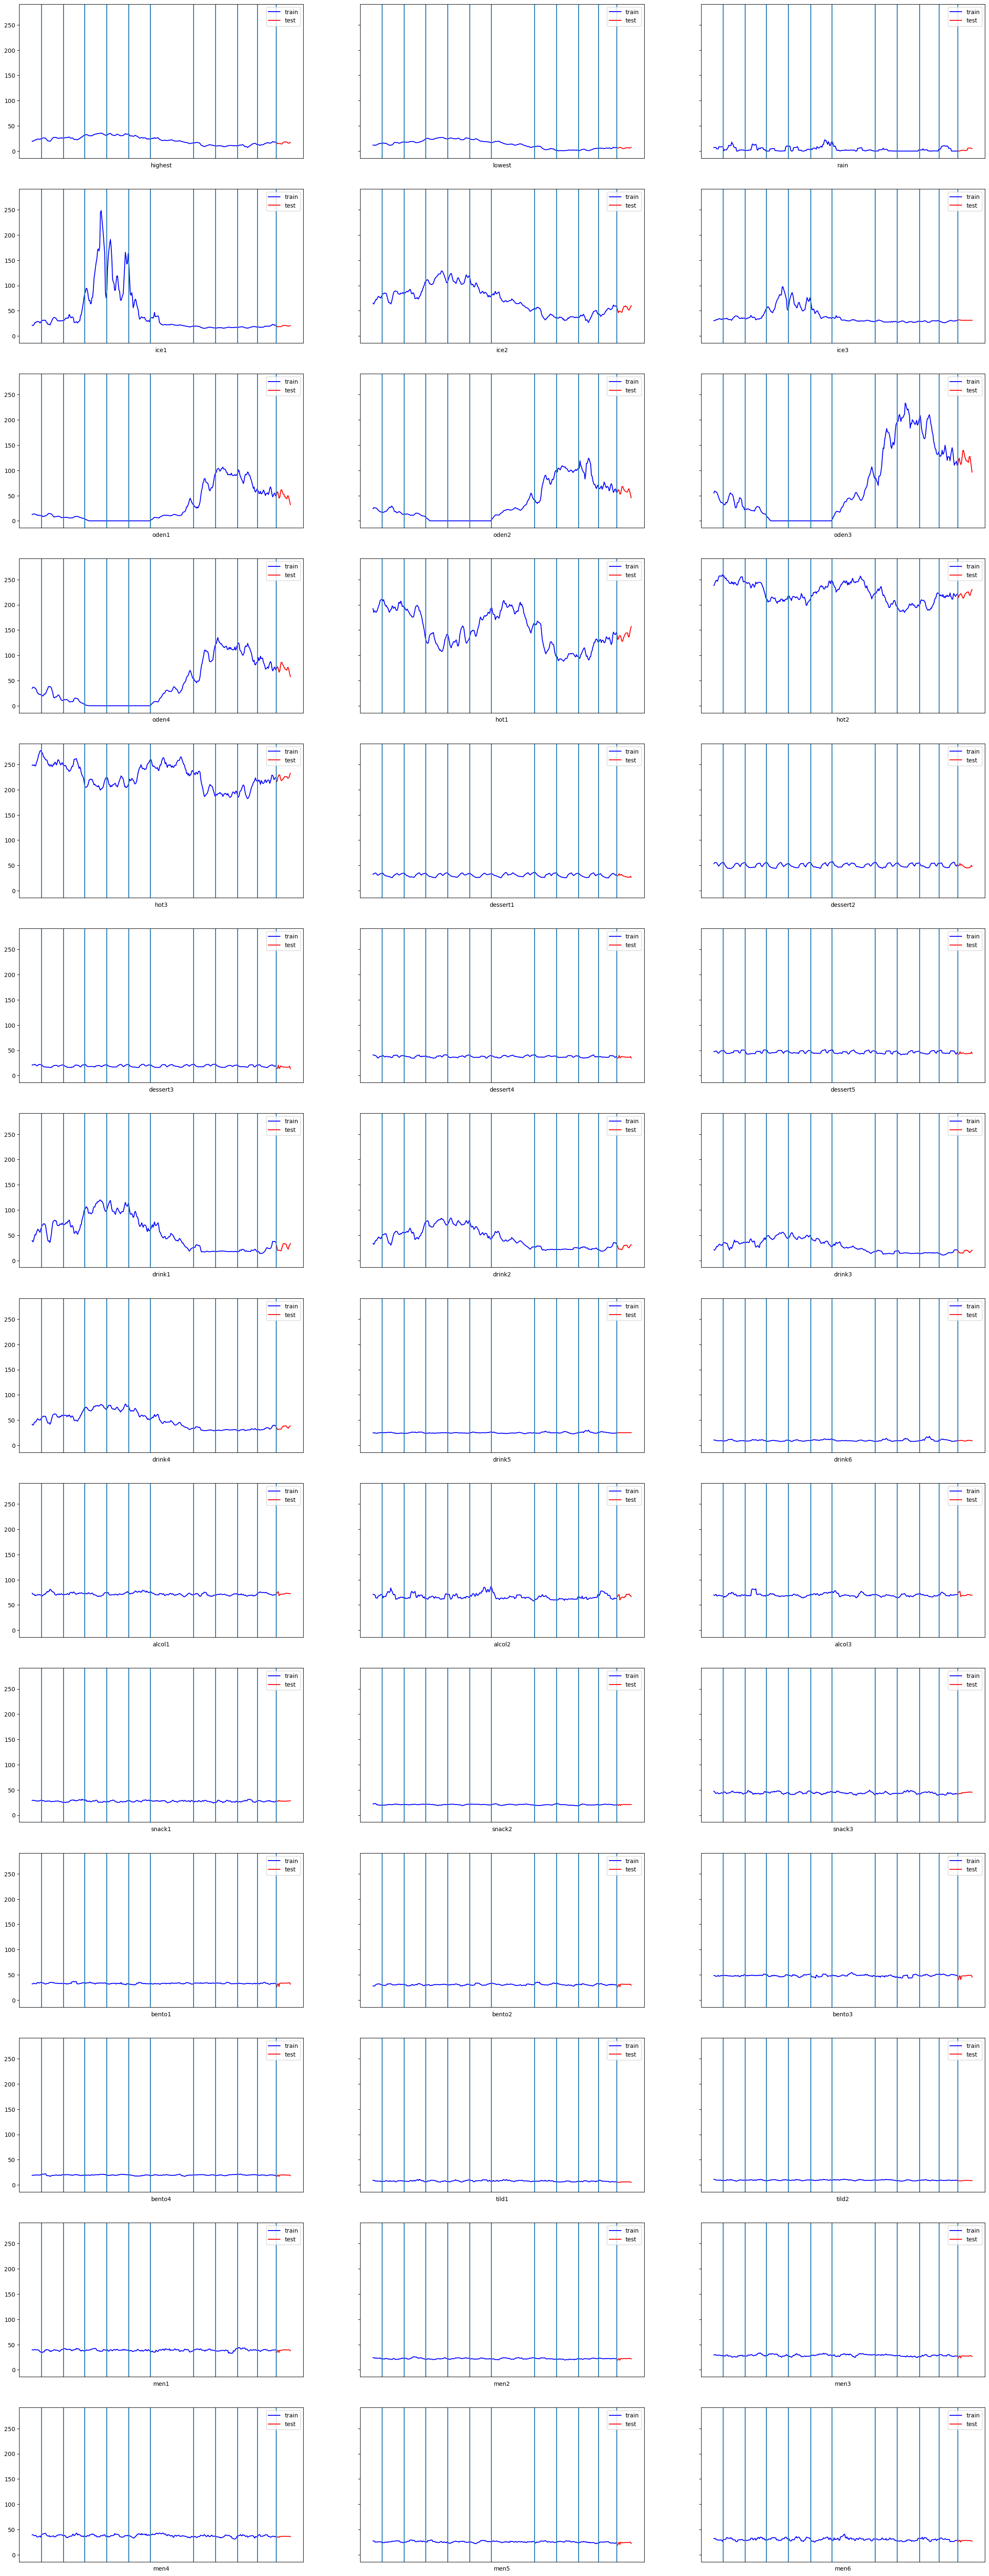

In [16]:
# 目視確認
plot_col = [c for c in train_df.columns if c not in ['id', 'date', 'time', 'year', 'month', 'day', 'weekday', 'day_of_year']]
ncols = len(plot_col) // 13
plt.subplots(14, ncols, sharey=True, sharex=True, figsize=(30, 80))
for i, col in enumerate(plot_col):
    plt.subplot(14, ncols, i+1)
    plt.plot(train_rolling.index[window:], train_rolling[col][window:], alpha=1, color='blue', label='train')
    plt.plot(all_rolling.index[-len(test_rolling):], all_rolling[col][-len(test_rolling):], alpha=1, color='red', label='test')
    for x in [20,51,81,112,143,173.204,234,265,296,324,350]:
        plt.axvline(x)
    plt.xlabel(col)
    plt.legend()
    plt.xticks([])
plt.show()